# Práctica 1: Procesamiento de datos mediante Apache Spark
By Luis Daniel Casais Mezquida, Lucas Gallego Bravo, Francisco Montañés de Lucas & Diego Picazo García  

Computación de Altas Prestaciones 24/25  
Máster en Ingeniería Informática, Universidad Carlos III de Madrid

## Setup

### Pyspark

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import unix_timestamp, col, to_utc_timestamp, from_utc_timestamp, when, try_divide, asc, desc



spark = SparkSession.builder.master('local[6]').getOrCreate()
#spark.conf.set('spark.cores.max', '2')
#spark.conf.set('spark.driver.memory','1000M')

sc = spark.sparkContext

!pip install psutil
from psutil import virtual_memory
print(f"Your runtime has {virtual_memory().total / 1e9:.1f} GiB of RAM, {spark.sparkContext.defaultParallelism} cores")

Your runtime has 33.6 GiB of RAM, 6 cores


### Import libraries

In [2]:
from datetime import datetime
import matplotlib.pyplot as plt
from time import perf_counter

#### Download data

In [3]:
#!wget https://aulaglobal.uc3m.es/pluginfile.php/7354849/mod_assign/introattachment/0/tripdata_2017-01.csv?forcedownload=1 -o tripdata_2017-01.csv
!wget https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv -O /home/jovyan/data/taxi_zone_lookup.csv
!wget https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-07.parquet -O /home/jovyan/data/yellow_tripdata_2024-07.parquet

--2024-10-31 11:06:58--  https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 3.160.226.228, 3.160.226.161, 3.160.226.85, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|3.160.226.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12331 (12K) [text/csv]
Saving to: ‘/home/jovyan/data/taxi_zone_lookup.csv’

/home/jovyan/data/t 100%[===================>]  12.04K  --.-KB/s    in 0s      

2024-10-31 11:06:58 (99.1 MB/s) - ‘/home/jovyan/data/taxi_zone_lookup.csv’ saved [12331/12331]

--2024-10-31 11:06:59--  https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-07.parquet
Resolving d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)... 3.160.226.161, 3.160.226.111, 3.160.226.228, ...
Connecting to d37ci6vzurychx.cloudfront.net (d37ci6vzurychx.cloudfront.net)|3.160.226.161|:443... connected.
HTTP request sent, awaiting respo

#### Load data

In [4]:
zone_map = spark.read.format("csv").option("inferSchema", "true").option("header", "true").option("mode", "DROPMALFORMED").load("/home/jovyan/data/taxi_zone_lookup.csv")
zone_map.show()
zone_map: dict[int, list[str]] = zone_map.toPandas().set_index('LocationID').T.to_dict('list')

+----------+-------------+--------------------+------------+
|LocationID|      Borough|                Zone|service_zone|
+----------+-------------+--------------------+------------+
|         1|          EWR|      Newark Airport|         EWR|
|         2|       Queens|         Jamaica Bay|   Boro Zone|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|
|         4|    Manhattan|       Alphabet City| Yellow Zone|
|         5|Staten Island|       Arden Heights|   Boro Zone|
|         6|Staten Island|Arrochar/Fort Wad...|   Boro Zone|
|         7|       Queens|             Astoria|   Boro Zone|
|         8|       Queens|        Astoria Park|   Boro Zone|
|         9|       Queens|          Auburndale|   Boro Zone|
|        10|       Queens|        Baisley Park|   Boro Zone|
|        11|     Brooklyn|          Bath Beach|   Boro Zone|
|        12|    Manhattan|        Battery Park| Yellow Zone|
|        13|    Manhattan|   Battery Park City| Yellow Zone|
|        14|     Brookly

In [5]:
# df = spark.read.format("csv").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load("data/tripdata_2017-01.csv")
df = spark.read.format("parquet").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load("/home/jovyan/data/yellow_tripdata_2024-07.parquet")
df.printSchema()
df.show(5)

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------

## Data preprocessing

In [6]:
# Conversion a unix timestamp:

# Definir la zona horaria
zona_horaria = "America/New_York"

# Considerando zona horaria:
df = df.withColumn("tpep_pickup_datetime", to_utc_timestamp(col("tpep_pickup_datetime"), zona_horaria))
# Convertir la columna 'tpep_pickup_datetime' a timestamp de Unix
df = df.withColumn("tpep_pickup_datetime", unix_timestamp(col("tpep_pickup_datetime")).cast("long"))

# Considerando zona horaria:
df = df.withColumn("tpep_dropoff_datetime", to_utc_timestamp(col("tpep_dropoff_datetime"), zona_horaria))
# Convertir la columna 'tpep_dropoff_datetime' a timestamp de Unix
df = df.withColumn("tpep_dropoff_datetime", unix_timestamp(col("tpep_dropoff_datetime")).cast("long"))

df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       1|          1719808496|           1719809209|              1|          3.2|         1|                 N|         140|          79|           1|       15.6|  3.5|    0.5|       3.

Ahora se eliman filas con valores nulos importantes que no se pueden sustituir

In [7]:
# Contar el número total de filas
numero_filas = df.count()

# Mostrar el resultado
print(f"Número total de filas en el DataFrame: {numero_filas}")

Número total de filas en el DataFrame: 3076903


In [8]:
df = df.dropna(subset=["VendorID"]) #Se eliminan filas con el número de VendorID nulo
df = df.dropna(subset=["tpep_pickup_datetime"]) #Se eliminan filas con el número de tpep_pickup_datetime nulo
df = df.dropna(subset=["tpep_dropoff_datetime"]) #Se eliminan filas con el número de tpep_dropoff_datetime nulo

# Eliminar filas donde 'passenger_count' sea '0'
df = df.filter(df.passenger_count != 0)

# Eliminar filas donde 'trip_distance' sea '0.0'
df = df.filter(df.trip_distance != 0)

# Eliminar filas donde 'tpep_pickup_datetime' es igual a 'tpep_dropoff_datetime'
df = df.filter(df.tpep_pickup_datetime != df.tpep_dropoff_datetime)

# Eliminar filas donde 'VendorID' no es 1 o 2:
df = df.filter(df.VendorID.isin([1,2]))

# Eliminar filas donde 'extra' no es mayor o igual a 0
df = df.filter(df.extra >= 0)

# Eliminar filas donde 'store_and_fwd_flag' no es "N" o "Y":
df = df.filter(df.store_and_fwd_flag.isin(["N","Y"]))

# Eliminar filas donde 'RatecodeID' no esta entre 1 y 6:
df = df.filter(df.RatecodeID.isin([1,2,3,4,5,6]))

# Eliminar filas donde 'payment_type' no esta entre 1 y 6:
df = df.filter(df.payment_type.isin([1,2,3,4,5,6]))

# Eliminar filas donde 'mta_tax' no sea 0.5
df = df.filter(df.mta_tax == 0.5)

# Eliminar filas donde 'improvement_surcharge' no sea mayor o igual a 0
df = df.filter((df.improvement_surcharge >= 0))

# Los siguientes se pueden/deben modificar dependiendo de que queramos

# Eliminar filas donde 'fare_amount' no este entre 0 y 100
df = df.filter((df.fare_amount >= 0) & (df.fare_amount <= 100))


# Eliminar filas donde 'tip_amount' no este entre 0 y 100
df = df.filter((df.tip_amount >= 0) & (df.tip_amount <= 100))


# Eliminar filas donde 'tolls_amount' no este entre 0 y 100
df = df.filter((df.tolls_amount >= 0) & (df.tolls_amount <= 100))

# Contar el número total de filas
numero_filas = df.count()
# Mostrar el resultado
print(f"Número total de filas en el DataFrame: {numero_filas}")

Número total de filas en el DataFrame: 2612531


In [9]:
df.describe().show()

+-------+-------------------+--------------------+---------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------+------------------+------------------+---------------------+------------------+--------------------+-------------------+
|summary|           VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|   passenger_count|    trip_distance|        RatecodeID|store_and_fwd_flag|      PULocationID|      DOLocationID|      payment_type|       fare_amount|             extra|mta_tax|        tip_amount|      tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|        Airport_fee|
+-------+-------------------+--------------------+---------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------+--------

## Q1: Velocidad media de los taxis en función de la hora
Usando RDDs.

Generamos la vista y el RDD.

In [10]:
df.createOrReplaceTempView("trips")
trips = df.select(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance']).rdd

Procesamos:
1. **Map:** Transformamos las _entries_ (viajes) en tuplas `(<hora>, <velocidad_media>)`
2. **Reduce:** Calculamos la media de las velocidades por cada hora
3. **Sort:** Ordenamos las horas de 0 a 23

In [11]:
# map & reduce
trips_rdd = trips.map(lambda x: (datetime.fromtimestamp(x[0]).hour, (3600 * x[2]) / (x[1] - x[0]))).reduceByKey(lambda x,y: (x+y)/2).sortBy(lambda x: x[0], ascending=True)

Transformamos los resultados en un DataFrame para generar la gráfica.

In [12]:
result = trips_rdd.toDF().withColumnRenamed("_1", "hour").withColumnRenamed("_2", "mean_mph")
result.show(result.count())

+----+------------------+
|hour|          mean_mph|
+----+------------------+
|   0|10.930676250928258|
|   1|12.295902208077262|
|   2|16.609354088537224|
|   3|14.202590258811833|
|   4|18.059157297794396|
|   5|12.953518363414364|
|   6| 16.86638915673185|
|   7| 18.48075187025212|
|   8|19.425315451401783|
|   9| 9.350717885356072|
|  10|3.8472140568790834|
|  11|  6.50748615487902|
|  12|10.227197613411537|
|  13|10.646597174598377|
|  14| 7.043975625729691|
|  15| 7.538175209764727|
|  16| 7.842086199183156|
|  17|  8.60950711544385|
|  18| 8.811420318242906|
|  19|   9.5815917959676|
|  20| 8.825039895591475|
|  21| 8.278031412462568|
|  22| 8.682638275340814|
|  23|12.068012086064266|
+----+------------------+



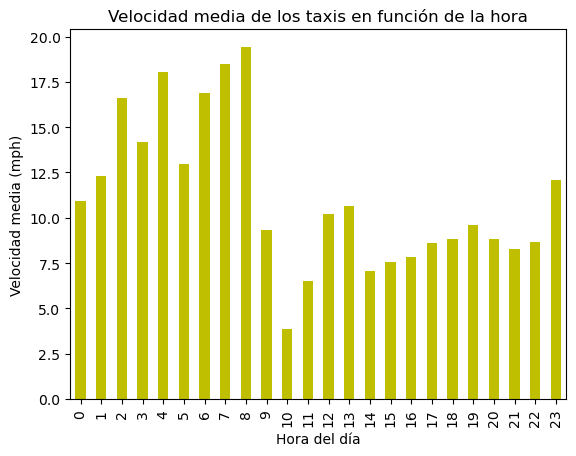

In [13]:
fig = result.toPandas().plot(
    kind = "bar",
    x = 'hour',
    y = 'mean_mph',
    ylabel = "Velocidad media (mph)",
    xlabel = "Hora del día",
    title = "Velocidad media de los taxis en función de la hora",
    legend = False,
    color = 'y'
)
fig.figure.savefig("/home/jovyan/output/q1.svg")

## Q2: Viajes en taxi más comunes

### SQL

In [14]:
df.createOrReplaceTempView("trips")
trips = spark.sql("""
  SELECT PULocationID, DOLocationID, count('x') as count
  FROM trips
  WHERE NOT PULocationID = 264
    AND NOT DOLocationID = 264
  GROUP BY PULocationID, DOLocationID
  SORT BY count DESC
  """
)
tic = perf_counter()
result_sql = trips.head(10)
time_sql = perf_counter() - tic

### Pyspark SQL

In [15]:
df.createOrReplaceTempView("trips")
trips = df.select(['PULocationID', 'DOLocationID']).where("NOT PULocationID = 264").where("NOT DOLocationID = 264").groupBy('PULocationID', 'DOLocationID').count().sort(desc('count'))

tic = perf_counter()
result_psql = trips.head(10)
time_psql = perf_counter() - tic

### RDD

In [16]:
df.createOrReplaceTempView("trips")
trips = df.select(['PULocationID', 'DOLocationID']).where("NOT PULocationID = 264").where("NOT DOLocationID = 264").rdd
trips_rdd = trips.map(lambda x: ((x[0], x[1]), 1)).reduceByKey(lambda x,y: x+y)

In [17]:
tic = perf_counter()
result = trips_rdd.sortBy(lambda x: x[1], ascending=False).take(10)
time_rdd = perf_counter() - tic

result_rdd = [
    (trip[0], trip[1], count)
    for trip, count in result
]

#### Resultados

In [18]:
assert result_sql == result_psql == result_rdd  # ensure same results

# sacar resultados
for pu, do, count in result_rdd:
    print(f"{zone_map[pu][1]} -> {zone_map[do][1]}: {count}")

Upper East Side South -> Upper East Side North: 15607
Upper East Side North -> Upper East Side South: 12701
Upper East Side South -> Upper East Side South: 11114
Upper East Side North -> Upper East Side North: 9546
Midtown Center -> Upper East Side South: 9404
Upper East Side South -> Midtown Center: 8467
Upper East Side South -> Midtown East: 8000
Midtown Center -> Upper East Side North: 7874
JFK Airport -> Times Sq/Theatre District: 7458
Upper East Side North -> Midtown Center: 6635


#### Eficiencia

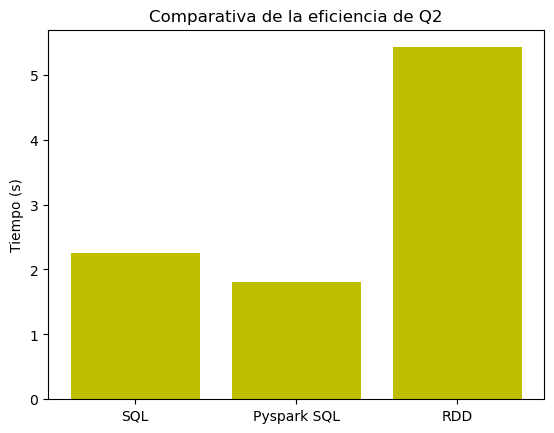

SQL: 2.2563933629999724
PSQL: 1.8012396359999912
RDD: 5.424472950999984


In [19]:
fig = plt.figure()
plt.bar(
    ["SQL", "Pyspark SQL", "RDD"],
    [time_sql, time_psql, time_rdd],
    color='y'
)
plt.plot()
plt.ylabel("Tiempo (s)")
plt.title("Comparativa de la eficiencia de Q2")
plt.show()

print(f"SQL: {time_sql}")
print(f"PSQL: {time_psql}")
print(f"RDD: {time_rdd}")

fig.savefig('/home/jovyan/output/q2_perf.svg')

## Q3: Porcentaje de propina por número de pasajeros

In [20]:
df.createOrReplaceTempView("trips")
trips = df.select(['passenger_count', 'tip_amount', 'total_amount'])
result = trips.select('passenger_count', try_divide(df['tip_amount'], df['total_amount']).alias("p")).groupBy('passenger_count').avg('p').sort(asc('passenger_count'))
result.show()
result = result.toPandas()

+---------------+-------------------+
|passenger_count|             avg(p)|
+---------------+-------------------+
|              1|0.12272298750536023|
|              2|0.11737468562219652|
|              3|0.10920092127126074|
|              4|0.09854396831660385|
|              5|0.12004119258221527|
|              6|0.12114629672810309|
|              7|0.16668346266250125|
|              8|0.12382452615636343|
+---------------+-------------------+



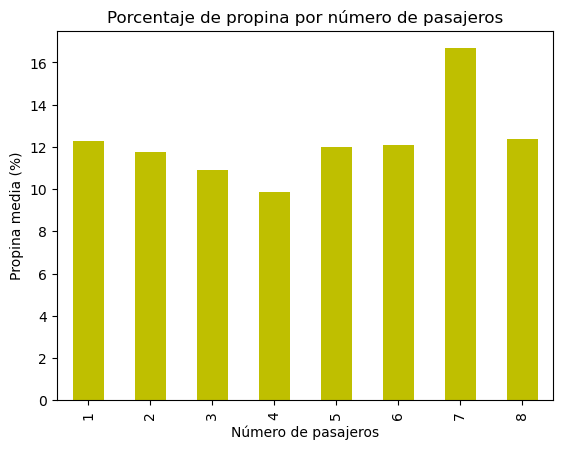

In [21]:
result.loc[:, 'avg(p)'] *= 100  # multiply avg by 100
fig = result.plot(
    kind = "bar",
    x = 'passenger_count',
    y = 'avg(p)',
    ylabel = "Propina media (%)",
    xlabel = "Número de pasajeros",
    title = "Porcentaje de propina por número de pasajeros",
    legend = False,
    color = 'y'
)
fig.figure.savefig("/home/jovyan/output/q3.svg")